In [1]:
%load_ext autoreload
%autoreload 2

In [61]:
import os
import os.path as osp
import sys

# sys.path.insert(0, 'some_dir')

import math
from tqdm.notebook import tqdm

from easydict import EasyDict as edict
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import transforms as T

import pytorch_lightning as pl
from torchsummaryX import summary

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [23]:
np.set_printoptions(linewidth=200)

In [3]:
import pickle

In [6]:
with open("/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/data/train.pkl", "rb") as f:
    train_data = pickle.load(f)

In [91]:
with open("/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/data/val.pkl", "rb") as f:
    val_data = pickle.load(f)

In [8]:
train_questions = [x[1] for x in train_data]

In [92]:
val_questions = [x[1] for x in val_data]

In [19]:
max_len = max([len(x) for x in train_questions])
train_questions_arr = np.empty((len(train_questions), max_len), dtype=np.int8)

for i, q in enumerate(train_questions):
    train_questions_arr[i, :len(q)] = q

In [93]:
max_val_len = max([len(x) for x in val_questions])
val_questions_arr = np.empty((len(val_questions), max_val_len), dtype=np.int8)

for i, q in enumerate(val_questions):
    val_questions_arr[i, :len(q)] = q

In [34]:
train_data[1]

('CLEVR_train_000000.png',
 [13, 14, 15, 6, 16, 2, 17, 18, 19, 20, 21, 18, 22, 23, 24, 25, 12],
 1,
 43)

In [35]:
train_answers_arr = np.array([x[2] for x in train_data])

In [94]:
val_answers_arr = np.array([x[2] for x in val_data])

In [63]:
uniques, inverse, counts = np.unique(train_questions_arr, axis=0, return_counts=True, return_inverse=True)

In [95]:
val_uniques, val_inverse, val_counts = np.unique(val_questions_arr, axis=0, return_counts=True, return_inverse=True)

In [68]:
from collections import defaultdict

In [70]:
groups = defaultdict(list)
for i, unique_idx in tqdm(enumerate(inverse)):
    groups[unique_idx].append(i)

In [96]:
val_groups = defaultdict(list)
for i, unique_idx in tqdm(enumerate(val_inverse)):
    val_groups[unique_idx].append(i)

In [88]:
question_answer_pairs = []
answers = []

for gid, group in tqdm(groups.items()):
    for i1, qid1 in enumerate(group):
        for i2, qid2 in enumerate(group[i1 + 1:]):
            if train_answers_arr[qid1] != train_answers_arr[qid2]:
                question_answer_pairs.append(((qid1, train_answers_arr[qid1]), (qid2, train_answers_arr[qid2])))
                answers.append(train_answers_arr[qid1])
                answers.append(train_answers_arr[qid2])

In [83]:
question_answer_pairs

[((1, 1), (158995, 5)),
 ((4, 4), (503580, 15)),
 ((316822, 4), (503580, 15)),
 ((11, 8), (624434, 6)),
 ((533014, 8), (624434, 6)),
 ((13, 9), (414027, 22)),
 ((29, 2), (197209, 0)),
 ((34, 8), (47123, 6)),
 ((47123, 6), (327461, 8)),
 ((47123, 6), (459877, 8)),
 ((35, 5), (133861, 11)),
 ((43, 15), (335957, 4)),
 ((43, 15), (642504, 4)),
 ((45, 11), (272304, 5)),
 ((45, 11), (350794, 18)),
 ((45, 11), (609342, 19)),
 ((45, 11), (657808, 1)),
 ((166214, 11), (272304, 5)),
 ((166214, 11), (350794, 18)),
 ((166214, 11), (609342, 19)),
 ((166214, 11), (657808, 1)),
 ((272304, 5), (350794, 18)),
 ((272304, 5), (424463, 11)),
 ((272304, 5), (609342, 19)),
 ((272304, 5), (657808, 1)),
 ((350794, 18), (424463, 11)),
 ((350794, 18), (609342, 19)),
 ((350794, 18), (657808, 1)),
 ((424463, 11), (609342, 19)),
 ((424463, 11), (657808, 1)),
 ((609342, 19), (657808, 1)),
 ((47, 8), (160033, 14)),
 ((47, 8), (178026, 14)),
 ((47, 8), (236195, 6)),
 ((47, 8), (563297, 14)),
 ((160033, 14), (236195, 

In [97]:
val_question_answer_pairs = []
val_answers = []

for gid, group in tqdm(val_groups.items()):
    for i1, qid1 in enumerate(group):
        for i2, qid2 in enumerate(group[i1 + 1:]):
            if val_answers_arr[qid1] != val_answers_arr[qid2]:
                val_question_answer_pairs.append(((qid1, val_answers_arr[qid1]), (qid2, val_answers_arr[qid2])))
                answers.append(val_answers_arr[qid1])
                answers.append(val_answers_arr[qid2])

In [90]:
with open("/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/data/train_complementary_pairs.pkl", "wb") as f:
    pickle.dump(question_answer_pairs, f)

In [98]:
with open("/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/data/val_complementary_pairs.pkl", "wb") as f:
    pickle.dump(val_question_answer_pairs, f)

# Complementary Dataset

In [99]:
sys.path.insert(0, '../src')

In [106]:
import h5py
from utils import load_vocab, idxs_to_question

In [121]:
class CLEVRCompDataset(Dataset):
    def __init__(self, base_dir, split="train"):
        self.base_dir = base_dir
        self.split = split
        self.data_dir = osp.join(self.base_dir, "data")

        self.vocab = load_vocab(base_dir)

        with open(osp.join(self.data_dir, f"{split}.pkl"), "rb") as f:
            self.data = pickle.load(f)

        with open(
            osp.join(self.data_dir, f"{split}_complementary_pairs.pkl"), "rb"
        ) as f:
            self.complementary_pairs = pickle.load(f)

        self.img = h5py.File(osp.join(self.data_dir, f"{split}_features.hdf5"), "r")
        if "features" in self.img.keys():
            dataset_name = "features"
        elif "data" in self.img.keys():
            dataset_name = "data"
        self.img = self.img[dataset_name]

    @property
    def __len(self):
        return len(self.complementary_pairs)

    def __getitem__(self, index):
        (qid1, _), (qid2, _) = self.complementary_pairs[index]

        img_fname1, question1, answer1, familiy1 = self.data[qid1]
        img_fname2, question2, answer2, familiy2 = self.data[qid2]

        qwords1 = idxs_to_question(question1, self.vocab["question_idx_to_token"])
        qwords2 = idxs_to_question(question2, self.vocab["question_idx_to_token"])

        aword1 = self.vocab["answer_idx_to_token"][answer1]
        aword2 = self.vocab["answer_idx_to_token"][answer2]

        iid1 = int(img_fname1.rsplit("_", 1)[1][:-4])
        iid2 = int(img_fname2.rsplit("_", 1)[1][:-4])

        img1 = torch.from_numpy(self.img[iid1])
        img2 = torch.from_numpy(self.img[iid2])

        return (
            dict(
                image=img1,
                question=question1,
                question_len=len(question1),
                answer=answer1,
                question_words=qwords1,
                answer_word=aword1,
                #  raw_image=img,
                question_idx=qid1,
                image_fname=img_fname1,
            ),
            dict(
                image=img2,
                question=question2,
                question_len=len(question2),
                answer=answer2,
                question_words=qwords2,
                answer_word=aword2,
                # raw_image=img,
                question_idx=qid2,
                image_fname=img_fname2,
            ),
        )

    def __len__(self):
        return len(self.complementary_pairs)

In [122]:
base_dir = "/Users/sebamenabar/Documents/datasets/CLEVR/CLEVR_v1.0/"
dataset = CLEVRCompDataset(base_dir, split="val")

In [123]:
dataset[0]

({'image': tensor([[[0.0000, 0.0174, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0610, 0.5053, 0.0000,  ..., 0.4097, 0.5801, 0.5672],
           [0.0000, 0.0152, 0.0000,  ..., 0.0000, 0.0000, 0.0307],
           ...,
           [0.0000, 0.2844, 0.0000,  ..., 0.0000, 0.0000, 0.0580],
           [0.0000, 0.3797, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.3576, 0.0000,  ..., 0.1440, 0.0000, 0.0788]],
  
          [[0.1281, 0.0000, 0.0000,  ..., 0.0000, 0.0049, 0.2248],
           [0.0928, 0.0994, 0.0000,  ..., 0.2364, 0.4906, 0.5254],
           [0.0567, 0.0000, 0.0000,  ..., 0.0107, 0.0762, 0.0944],
           ...,
           [0.0333, 0.1636, 0.0000,  ..., 0.0000, 0.0000, 0.2576],
           [0.0982, 0.1129, 0.0000,  ..., 0.0000, 0.0474, 0.1777],
           [0.2115, 0.2368, 0.0297,  ..., 0.2330, 0.2156, 0.2051]],
  
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0

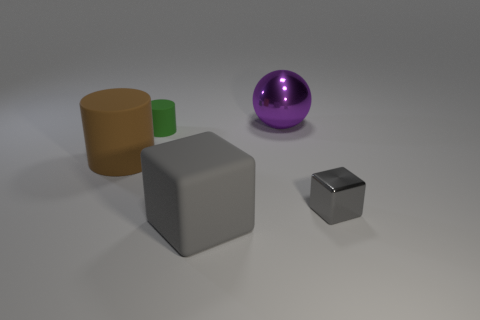

In [125]:
Image.open(osp.join(base_dir, "images", "val", "CLEVR_val_000000.png"))

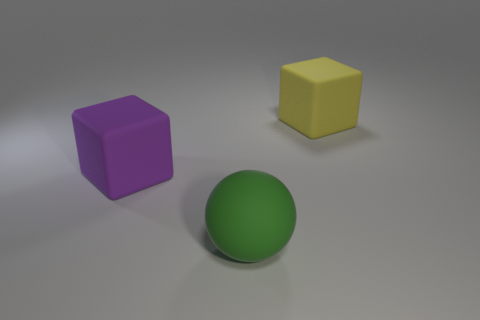

In [124]:
Image.open(osp.join(base_dir, "images", "val", "CLEVR_val_002139.png"))

# Modeling

In [140]:
from config import cfg
from mac import load_MAC

from datasets.datasets import collate_fn

In [129]:
vocab = load_vocab(base_dir)
mac = load_MAC(cfg.model.mac, vocab)

In [130]:
import higher

In [162]:
cfg.model.mac.input_unit.in_channels = 1024
mac, _ = load_MAC(cfg.model.mac, vocab)
opt = torch.optim.Adam(mac.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

pbar = tqdm(range(10))
for _ in pbar:
    with higher.innerloop_ctx(mac, opt) as (fmodel, diffopt):
        sample = dataset[0]

        outer_sample = collate_fn([sample[0]])
        inner_sample = collate_fn([sample[1]])

        pred = fmodel(inner_sample["image"], inner_sample["question"], inner_sample["question_length"])
        inner_loss = criterion(pred, inner_sample["answer"])

        diffopt.step(inner_loss)

        outer_pred = fmodel(outer_sample["image"], outer_sample["question"], outer_sample["question_length"])
        outer_loss = criterion(outer_pred, outer_sample["answer"])
        outer_loss.backward()

        opt.step()
        
        pbar.set_postfix(outer_loss=outer_loss.item())

In [148]:
pred

tensor([[-0.1774,  0.2452, -0.0519, -0.2373, -0.1980, -0.6655,  0.4350,  0.6691,
          0.1206, -0.2316, -0.5306, -0.1823,  0.3947, -1.5566,  0.8204, -0.8584,
         -0.1058, -0.2673, -0.4125,  0.6151, -0.0108, -0.7972,  0.6974,  1.4649,
         -0.7737, -0.3021,  0.4725,  0.0956]], grad_fn=<AddmmBackward>)

In [144]:
outer_sample

{'image': tensor([[[[0.0000, 0.0174, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0610, 0.5053, 0.0000,  ..., 0.4097, 0.5801, 0.5672],
           [0.0000, 0.0152, 0.0000,  ..., 0.0000, 0.0000, 0.0307],
           ...,
           [0.0000, 0.2844, 0.0000,  ..., 0.0000, 0.0000, 0.0580],
           [0.0000, 0.3797, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.3576, 0.0000,  ..., 0.1440, 0.0000, 0.0788]],
 
          [[0.1281, 0.0000, 0.0000,  ..., 0.0000, 0.0049, 0.2248],
           [0.0928, 0.0994, 0.0000,  ..., 0.2364, 0.4906, 0.5254],
           [0.0567, 0.0000, 0.0000,  ..., 0.0107, 0.0762, 0.0944],
           ...,
           [0.0333, 0.1636, 0.0000,  ..., 0.0000, 0.0000, 0.2576],
           [0.0982, 0.1129, 0.0000,  ..., 0.0000, 0.0474, 0.1777],
           [0.2115, 0.2368, 0.0297,  ..., 0.2330, 0.2156, 0.2051]],
 
          [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
           [0.0

In [139]:
outer_sample

{'image': tensor([[[0.0000, 0.0174, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0610, 0.5053, 0.0000,  ..., 0.4097, 0.5801, 0.5672],
          [0.0000, 0.0152, 0.0000,  ..., 0.0000, 0.0000, 0.0307],
          ...,
          [0.0000, 0.2844, 0.0000,  ..., 0.0000, 0.0000, 0.0580],
          [0.0000, 0.3797, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.3576, 0.0000,  ..., 0.1440, 0.0000, 0.0788]],
 
         [[0.1281, 0.0000, 0.0000,  ..., 0.0000, 0.0049, 0.2248],
          [0.0928, 0.0994, 0.0000,  ..., 0.2364, 0.4906, 0.5254],
          [0.0567, 0.0000, 0.0000,  ..., 0.0107, 0.0762, 0.0944],
          ...,
          [0.0333, 0.1636, 0.0000,  ..., 0.0000, 0.0000, 0.2576],
          [0.0982, 0.1129, 0.0000,  ..., 0.0000, 0.0474, 0.1777],
          [0.2115, 0.2368, 0.0297,  ..., 0.2330, 0.2156, 0.2051]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.4218, 0.20